In [96]:
%pip install numpy pandas matplotlib seaborn missingno importlib-metadata scikit-learn keras jinja2 feature_engine torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import importlib
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch
import cudf

In [2]:
# Check GPU availability
print(f"CUDA supported: {torch.cuda.is_available()}")  # Should return True[2][5]

# Confirm CUDA version
print(f"PyTorch CUDA version: {torch.version.cuda}")  # e.g., 12.1[5]

# Check GPU details
print(f"Device count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA supported: True
PyTorch CUDA version: 12.6
Device count: 1
Current device: 0
Device name: NVIDIA RTX A6000


In [3]:
# Init the Processor
import ORAN_Helper, Models

importlib.reload(ORAN_Helper)
processor = ORAN_Helper.Processor()
plotter = ORAN_Helper.Plotter(plt=plt,sns=sns)

def reload_all():
    global processor, plotter, models
    importlib.reload(ORAN_Helper)
    processor = ORAN_Helper.Processor()
    plotter = ORAN_Helper.Plotter(plt=plt,sns=sns)
    
    importlib.reload(Models)

2025-05-07 11:43:16.716261: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 11:43:16.727346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746598396.740911  213506 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746598396.744829  213506 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746598396.755056  213506 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
file_path_1 = "FBSDetector/dataset/fbs_nas.csv"
file_path_2=  "FBSDetector/dataset/fbs_rrc.csv"

In [157]:
fbs_nas = pd.read_csv(file_path_1, index_col = 0)
fbs_rrc = pd.read_csv(file_path_2, index_col = 0)

print(f"fbs_nas: {fbs_nas.shape}")
print(f"fbs_rrc: {fbs_rrc.shape}")

fbs_nas: (1640, 421)
fbs_rrc: (1037, 939)


### Dropping the duplicate data

In [158]:
fbs_nas.drop_duplicates(inplace=True)
fbs_rrc.drop_duplicates(inplace=True)

print(f"fbs_nas: {fbs_nas.shape}")
print(f"fbs_rrc: {fbs_rrc.shape}")

fbs_nas: (904, 421)
fbs_rrc: (456, 939)


#### Checking for Infinite values

In [159]:
fbs_nas.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Number of Infinite values in FBS NAS: {fbs_nas.isna().sum().sum()}")

fbs_rrc.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Number of Infinite values in FBS RRC: {fbs_rrc.isna().sum().sum()}")

Number of Infinite values in FBS NAS: 0
Number of Infinite values in FBS RRC: 0


#### Checking for the Labels

### Lables are 0 -> benign, 1 -> Attack

##### Counting the number of each Label

In [160]:
fn = fbs_nas['label'].value_counts()

print(f"FBS NAS \n {fn}")

fr = fbs_rrc['label'].value_counts()

print(f"\n\nFBS RRC \n {fr}")

FBS NAS 
 label
0    597
1    307
Name: count, dtype: int64


FBS RRC 
 label
0    349
1    107
Name: count, dtype: int64


In [161]:
reload_all()
fn_dict = fn.to_dict()
key_mapping = {0: "Benign", 1: "FBS"}
updated_dict_nas = {}

for key in fn_dict.keys():
    updated_dict_nas[key_mapping[key]] = fn_dict[key]

print(updated_dict_nas)

fr_dict = fr.to_dict()
updated_dict_rrc = {}

for key in fn_dict.keys():
    updated_dict_rrc[key_mapping[key]] = fr_dict[key]

print(updated_dict_rrc)



{'Benign': 597, 'FBS': 307}
{'Benign': 349, 'FBS': 107}


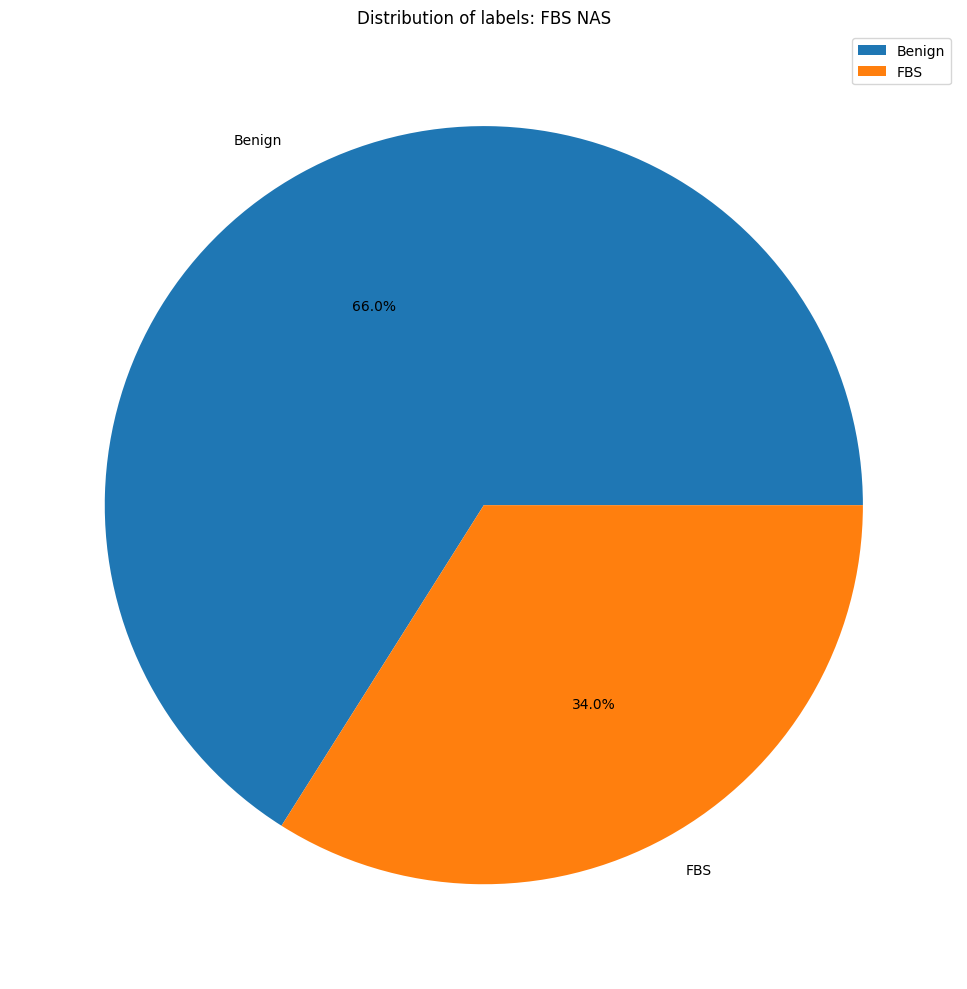

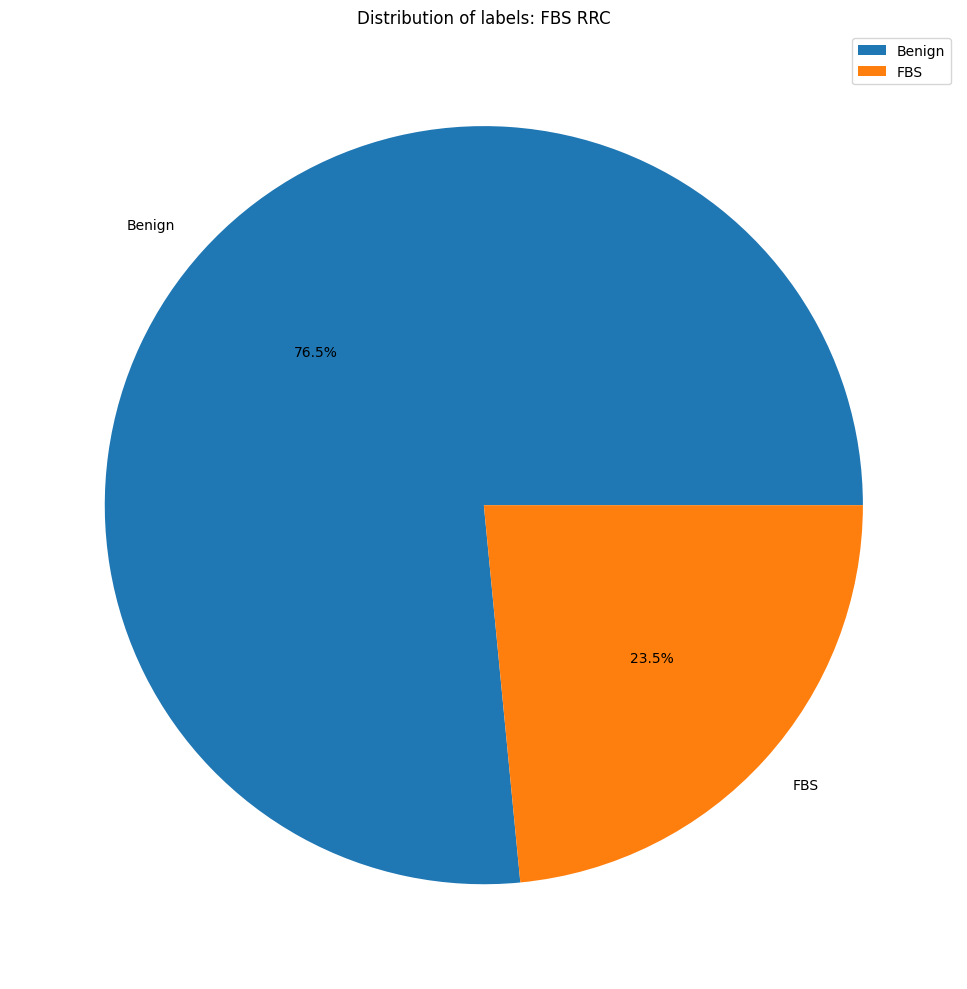

In [162]:
plotter.plot_dict(updated_dict_nas,type="pie",fig_dimx=10, fig_dimy=10, title="Distribution of labels: FBS NAS")
plotter.plot_dict(updated_dict_rrc,type="pie",fig_dimx=10, fig_dimy=10, title="Distribution of labels: FBS RRC")

#### Finding the correlation among the features

##### Separating data and labels

In [163]:
reload_all()
fbs_nas_data, fbs_nas_labels = processor.separate_label(fbs_nas, label_name="label")
fbs_rrc_data, fbs_rrc_labels = processor.separate_label(fbs_rrc, label_name="label")

In [164]:
corr_matrix_fbs_nas = fbs_nas_data.corr().round(3)
corr_matrix_fbs_rrc = fbs_rrc_data.corr().round(3)

In [165]:
reload_all()
high_corr_pairs_fbs_nas = processor.get_correlated_features(corr_matrix_fbs_nas, Threshold=0.95, print_it=False)
high_corr_pairs_fbs_rrc = processor.get_correlated_features(corr_matrix_fbs_rrc, Threshold=0.95, print_it=False)

Number of Highly Co-related feature pairs: 17626 


Number of Highly Co-related feature pairs: 68062 




### Dropping really high correlated features

In [166]:
reload_all()

fbs_nas_data_processed = processor.drop_correlated_features(high_corr_pairs=high_corr_pairs_fbs_nas, data=fbs_nas_data)
fbs_rrc_data_processed = processor.drop_correlated_features(high_corr_pairs=high_corr_pairs_fbs_rrc, data=fbs_rrc_data)

Number of features to be dropped: 356
{'nas_eps_emm_epco_value', 'gsm_a_ie_mobileid_type_value', 'nas_eps_emm_tai_tol_unmaskedvalue', 'gsm_a_dtap_add_ci_unmaskedvalue', 'nas_eps_emm_eia7_value', 'nas_eps_emm_cp_ciot_size', 'nas_eps_security_header_type_show', 'nas_eps_emm_cause_value', 'nas_eps_emm_restrict_dcnr_size', 'nas_eps_emm_eea0_show', 'nas_eps_emm_tai_n_elem_show', 'gsm_a_oddevenind_value', 'nas_eps_emm_ebi8_show', 'nas_eps_emm_ebi6_value', 'nas_eps_emm_ebi5_unmaskedvalue', 'nas_eps_spare_bits_size', 'nas_eps_emm_ebi13_show', 'nas_eps_emm_s1_u_data_size', 'nas_eps_emm_up_ciot_show', 'gsm_a_common_elem_id_show', 'nas_eps_emm_eia6_value', 'e212_mnc_show', 'nas_eps_emm_ebi2_unmaskedvalue', 'nas_eps_emm_ebi7_unmaskedvalue', 'nas_eps_emm_ebi3_show', 'nas_eps_emm_s1_u_data_value', 'nas_eps_emm_esm_msg_cont_size', 'nas_eps_emm_EPS_attach_result_show', 'nas_eps_emm_ebi6_show', 'nas_eps_emm_eia4_value', 'nas_eps_emm_eia4_show', 'nas_eps_emm_ebi13_value', 'gsm_a_dtap_number_of_spare_bit

In [167]:
print(f"fbs_nas: {fbs_nas_data_processed.shape}")
print(f"fbs_nas: {fbs_rrc_data_processed.shape}")

fbs_nas: (904, 64)
fbs_nas: (456, 88)


##### Creating one set for addition

In [168]:
to_add_fbs_nas = set()
to_add_fbs_rrc = set()

##### Features which are highly correlated with the label

In [169]:
reload_all()
fbs_nas_label_high_corr_features = processor.get_features_corr_with_label(data=fbs_nas, label_name="label",threshold=0.4)
fbs_rrc_label_high_corr_features = processor.get_features_corr_with_label(data=fbs_rrc, label_name="label",threshold=0.4)

# Adding these features in the set
to_add_fbs_nas.update(fbs_nas_label_high_corr_features)
to_add_fbs_rrc.update(fbs_rrc_label_high_corr_features)


#### Coutning for the number of unique values

FBS-NAS

Unique Value cout for:
1   nas_eps_emm_nas_key_set_id_value: 5
2   nested_field2_size            : 6
3   nas_eps_seq_no_value          : 29
4   gsm_a_L3_protocol_discriminator_value: 1
5   nas_eps_nas_msg_emm_type_size : 1
6   nas_eps_emm_cause_size        : 2
7   nas_eps_emm_esm_msg_cont_value: 58
8   gsm_a_L3_protocol_discriminator_size: 1
9   nas_eps_emm_nas_key_set_id_show: 3
10  nas_eps_emm_res_size          : 2
11  gsm_a_dtap_rand_value         : 245
12  nas_eps_msg_auth_code_show    : 550
13  nested_field4_value           : 122
14  gsm_a_dtap_time_zone_time_show: 105
15  nas_eps_common_elem_id_show   : 3
16  nas_eps_security_header_type_size: 1
17  e212_assoc_imsi_size          : 2
18  nested_field3_value           : 163
19  nested_field1_size            : 9
20  nas_eps_emm_detach_type_ul_size: 2
21  nested_field4_show            : 7
22  nas_eps_emm_elem_id_show      : 5
23  nas_eps_emm_spare_half_octet_show: 2
24  gsm_a_L3_protocol_discriminator_show: 1
25  nas_eps_spare_bits_v

/home/ashutosh/O-RADAR/ORAN_Helper.py:268: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


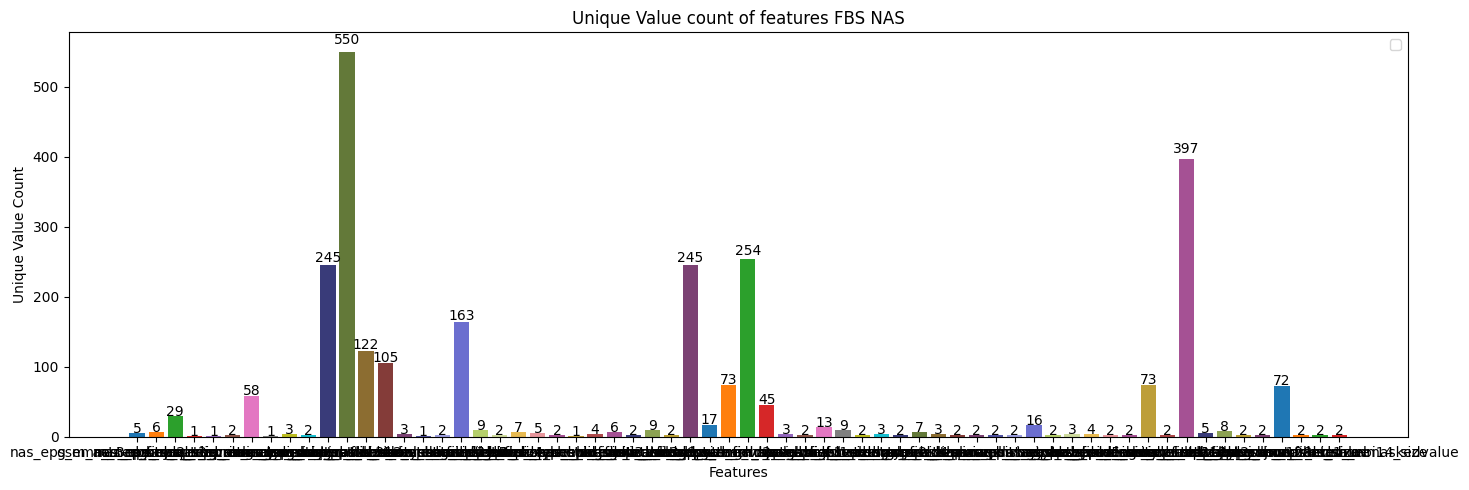

In [170]:
reload_all()
unique_dict_fbs_nas = processor.get_unique_values_for_each_feature(data=fbs_nas_data_processed, print_it = True)
plotter.plot_dict(unique_dict_fbs_nas, fig_dimx=15, fig_dimy=5, title="Unique Value count of features FBS NAS", x_label="Features", y_label="Unique Value Count")


FBS-RRC

Unique Value cout for:
1   per_extension_bit_showname    : 5
2   lte-rrc_DL_CCCH_Message_element_name: 2
3   per_extension_present_bit_showname: 3
4   lte-rrc_dedicatedInfoType_size: 9
5   lte-rrc_pagingRecordList_show : 5
6   lte-rrc_UL_DCCH_Message_element_size: 14
7   lte-rrc_c1_showname           : 20
8   lte-rrc_schedulingInfoSIB1_BR_r13_value: 43
9   lte-rrc_rrc_TransactionIdentifier_value: 10
10  lte-rrc_c1_show               : 10
11  lte-rrc_criticalExtensions_showname: 7
12  lte-rrc_nonCriticalExtension_element_size: 3
13  lte-rrc_trackingAreaCode_show : 3
14  per_octet_string_length_show  : 13
15  lte-rrc_BCCH_DL_SCH_Message_element_size: 3
16  per_sequence_of_length_show   : 6
17  lte-rrc_c_RNTI_value          : 4
18  per_enum_index_value          : 28
19  per_enum_index_pos            : 12
20  per_extension_bit_size        : 2
21  lte-rrc_spare_show            : 2
22  per_octet_string_length_showname: 13
23  lte-rrc_rrc_TransactionIdentifier_name: 2
24  lte-rrc_paging_eleme

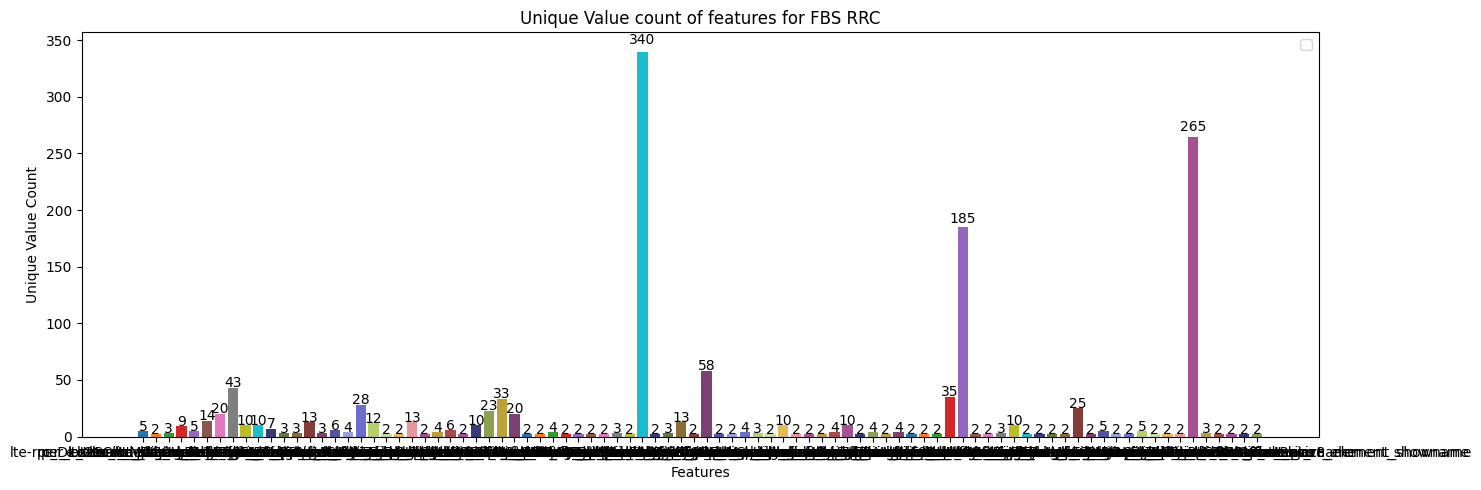

In [171]:
reload_all()
unique_dict_fbs_rrc = processor.get_unique_values_for_each_feature(data=fbs_rrc_data_processed, print_it = True)
plotter.plot_dict(unique_dict_fbs_rrc, fig_dimx=15, fig_dimy=5, title="Unique Value count of features for FBS RRC", x_label="Features", y_label="Unique Value Count")


##### Now removing the features where all the values are same

In [172]:
reload_all()
fbs_nas_remove_feature_with_single_count_list = processor.remove_features_with_unique_count(data=fbs_nas_data_processed, unique_dict=unique_dict_fbs_nas, unique_count=1, remove=False)
fbs_rrc_remove_feature_with_single_count_list = processor.remove_features_with_unique_count(data=fbs_rrc_data_processed, unique_dict=unique_dict_fbs_rrc, unique_count=1, remove=False)



In [173]:
# Dropping the features with unique count as 1

fbs_nas_data_processed.drop(columns=fbs_nas_remove_feature_with_single_count_list, inplace=True)
fbs_rrc_data_processed.drop(columns=fbs_rrc_remove_feature_with_single_count_list, inplace=True)



##### Now checking the features with zero standard deviation

In [174]:
fbs_nas_data_processed_zero_std = processor.features_with_zero_std(data=fbs_nas_data_processed)
fbs_rrc_data_processed_zero_std = processor.features_with_zero_std(data=fbs_rrc_data_processed)

print(fbs_nas_data_processed_zero_std)
print(fbs_rrc_data_processed_zero_std)



[]
[]


In [175]:
print(fbs_nas_data_processed.shape)
print(fbs_rrc_data_processed.shape)

(904, 59)
(456, 88)


##### Now adding the features which have high correlation with the label

In [176]:
for feature in to_add_fbs_nas:
    if feature in fbs_nas_data_processed.columns or feature in fbs_nas_remove_feature_with_single_count_list:
        continue
    
    fbs_nas_data_processed[feature] = fbs_nas_data[feature]


for feature in to_add_fbs_rrc:
    if feature in fbs_rrc_data_processed.columns or feature in fbs_rrc_remove_feature_with_single_count_list:
        continue

    fbs_rrc_data_processed[feature] = fbs_rrc_data[feature]


print(fbs_nas_data_processed.shape)
print(fbs_rrc_data_processed.shape)

(904, 65)
(456, 88)


##### Printing the selected features for FBS NAS

In [177]:
for feature in fbs_nas_data_processed.columns:
    print(feature)

nas_eps_emm_nas_key_set_id_value
nested_field2_size
nas_eps_seq_no_value
nas_eps_emm_cause_size
nas_eps_emm_esm_msg_cont_value
nas_eps_emm_nas_key_set_id_show
nas_eps_emm_res_size
gsm_a_dtap_rand_value
nas_eps_msg_auth_code_show
nested_field4_value
gsm_a_dtap_time_zone_time_show
nas_eps_common_elem_id_show
e212_assoc_imsi_size
nested_field3_value
nested_field1_size
nas_eps_emm_detach_type_ul_size
nested_field4_show
nas_eps_emm_elem_id_show
nas_eps_emm_spare_half_octet_show
nas_eps_spare_bits_value
nested_field3_size
nas_eps_emm_elem_id_size
gsm_a_len_value
nested_field6_value
gsm_a_dtap_autn_show
nas_eps_nas_msg_emm_type_show
3gpp_tmsi_value
nested_field2_value
nas_eps_emm_hash_mme_value
nas_eps_emm_spare_half_octet_value
gsm_a_id_dig_1_size
nested_field1_show
gsm_a_len_show
nas_eps_emm_id_type2_size
nas_eps_emm_cause_show
nas_eps_spare_bits_show
nested_field4_size
gsm_a_len_size
gsm_a_dtap_rand_size
gsm_a_spare_bits_size
nas_eps_emm_tsc_show
nas_eps_emm_update_type_value_show
nas_eps_

##### Printing the selected features for FBS RRC

In [178]:
for feature in fbs_rrc_data_processed.columns:
    print(feature)

per_extension_bit_showname
lte-rrc_DL_CCCH_Message_element_name
per_extension_present_bit_showname
lte-rrc_dedicatedInfoType_size
lte-rrc_pagingRecordList_show
lte-rrc_UL_DCCH_Message_element_size
lte-rrc_c1_showname
lte-rrc_schedulingInfoSIB1_BR_r13_value
lte-rrc_rrc_TransactionIdentifier_value
lte-rrc_c1_show
lte-rrc_criticalExtensions_showname
lte-rrc_nonCriticalExtension_element_size
lte-rrc_trackingAreaCode_show
per_octet_string_length_show
lte-rrc_BCCH_DL_SCH_Message_element_size
per_sequence_of_length_show
lte-rrc_c_RNTI_value
per_enum_index_value
per_enum_index_pos
per_extension_bit_size
lte-rrc_spare_show
per_octet_string_length_showname
lte-rrc_rrc_TransactionIdentifier_name
lte-rrc_paging_element_size
per_enum_index_showname
lte-rrc_ue_CapabilityRequest_showname
lte-rrc_DL_DCCH_Message_element_size
lte-rrc_m_TMSI_value
lte-rrc_dedicatedInfoNASList_value
lte-rrc_establishmentCause_value
per_extension_present_bit_size
lte-rrc_dedicatedInfoType_show
lte-rrc_PCCH_Message_element

##### Scaling the data

In [179]:
fbs_nas_data_processed_scaled = processor.scaler(data_without_labels=fbs_nas_data_processed, type="min_max")
fbs_rrc_data_processed_scaled = processor.scaler(data_without_labels=fbs_rrc_data_processed, type="min_max")



##### Splitting the test and the training data

In [180]:
X_train, X_test,y_train, y_test = train_test_split(fbs_nas_data_processed_scaled, fbs_nas_labels, test_size=0.2,random_state=42)


#### Applying MLP

In [276]:
reload_all()

mlp = Models.MLP(number_of_features=X_train.shape[1], learning_rate=0.01, dataloader=-1)
mlp.fit(X_train=X_train, y_train=y_train, epochs=300)



Using device: cuda
Epoch 1 ---->>>>>>>>>>, Loss: 0.7104, Train Accuracy: 0.3250

Epoch 30 ---->>>>>>>>>>, Loss: 0.3639, Train Accuracy: 0.7981

Epoch 60 ---->>>>>>>>>>, Loss: 0.3222, Train Accuracy: 0.8562

Epoch 90 ---->>>>>>>>>>, Loss: 0.2988, Train Accuracy: 0.8603

Epoch 120 ---->>>>>>>>>>, Loss: 0.2924, Train Accuracy: 0.8631

Epoch 150 ---->>>>>>>>>>, Loss: 0.2865, Train Accuracy: 0.8617

Epoch 180 ---->>>>>>>>>>, Loss: 0.2835, Train Accuracy: 0.8658

Epoch 210 ---->>>>>>>>>>, Loss: 0.2776, Train Accuracy: 0.8658

Epoch 240 ---->>>>>>>>>>, Loss: 0.2752, Train Accuracy: 0.8672

Epoch 270 ---->>>>>>>>>>, Loss: 0.2725, Train Accuracy: 0.8686

Epoch 300 ---->>>>>>>>>>, Loss: 0.2706, Train Accuracy: 0.8700


Time Taken    : 0.47 sec
--Final Accuracy    : 0.47 sec
--Best Accuracy: 87.41355463347165, epoch no. 253


In [277]:
fbs_nas_mlp_metrics = mlp.evaluate_and_get_metrics(X_test=X_test, y_test=y_test)


Overall Metrics: 

--Test Accuracy: 81.76795580110497
--Best Training Accuracy: 87.41355463347165, epoch no. 253
--Macro F1-Score: 0.8110

Class-wise Metrics:
--Precision: 0.76
--Recall: 0.791667
--F1-Score: 0.7755102040816326


Time Taken By the model: 0.47452759742736816 seconds 


Number of Test labels: 181


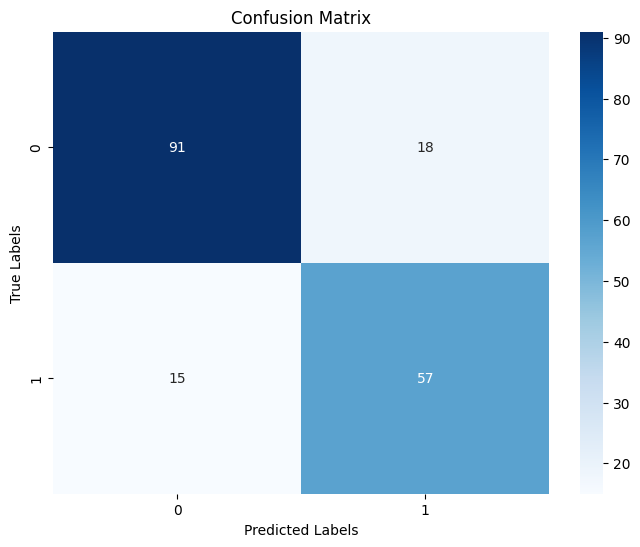

In [284]:
reload_all()
fbs_nas_mlp_metrics.print_metrics()

plotter.plot_confusion_matrix(fbs_nas_mlp_metrics.cf_matrix, total_labels=fbs_nas_labels, test_labels=y_test)

##### Testing the model on the test set

Len of ttaining loss: [0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354]
Time taken by the model: 0.1438465118408203


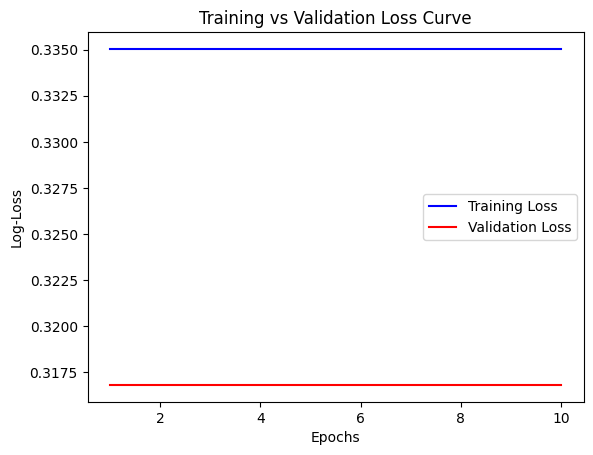

In [116]:
reload_all()

lr = Models.LR()
lr.fit(X_train=X_train, y_train=y_train, epochs=10)

In [98]:
reload_all()
lr_fbs_nas_metrics = lr.evaluate_and_get_metrics(X_test=X_test, y_test=y_test)

In [99]:
lr_fbs_nas_metrics.print_metrics()


Overall Metrics: 

--Test Accuracy: 82.87292817679558
--Macro F1-Score: 0.8245

Class-wise Metrics:
--Precision: 0.7530864197530864
--Recall: 0.847222
--F1-Score: 0.7973856209150327


Time Taken By the model: 0.022866010665893555 seconds 


